In [ ]:
# Installing required libraries
!pip install -q kaggle
!pip install -q seaborn
!pip install -q scikit-learn
!pip -q install timm
!git clone https://github.com/HealthInnovators/kaggle-skin.git

!mkdir -p ~/.kaggle
!cp kaggle-skin/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c isic-2024-challenge
!unzip isic-2024-challenge.zip -d isic2024/


Streaming output truncated to the last 5000 lines.
  inflating: isic2024/train-image/image/ISIC_9874656.jpg  
  inflating: isic2024/train-image/image/ISIC_9874659.jpg  
  inflating: isic2024/train-image/image/ISIC_9874663.jpg  
  inflating: isic2024/train-image/image/ISIC_9874742.jpg  
  inflating: isic2024/train-image/image/ISIC_9874751.jpg  
  inflating: isic2024/train-image/image/ISIC_9874803.jpg  
  inflating: isic2024/train-image/image/ISIC_9874805.jpg  
  inflating: isic2024/train-image/image/ISIC_9874832.jpg  
  inflating: isic2024/train-image/image/ISIC_9874878.jpg  
  inflating: isic2024/train-image/image/ISIC_9874897.jpg  
  inflating: isic2024/train-image/image/ISIC_9874925.jpg  
  inflating: isic2024/train-image/image/ISIC_9874931.jpg  
  inflating: isic2024/train-image/image/ISIC_9874939.jpg  
  inflating: isic2024/train-image/image/ISIC_9874940.jpg  
  inflating: isic2024/train-image/image/ISIC_9874963.jpg  
  inflating: isic2024/train-image/image/ISIC_9874987.jpg  
  inf

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image
import pandas as pd
import os
from torch.utils.data import DataLoader,random_split

from torchvision.transforms import v2
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from timm import create_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class ISICDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+".jpg")
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
transforms = v2.Compose([
    v2.Resize(size=(224,224)),
    v2.RandomHorizontalFlip(0.6),
    v2.RandomVerticalFlip(0.6),
    v2.RandomAffine(10),
    v2.GaussianBlur(3),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = ISICDataset('isic2024/train-metadata.csv','isic2024/train-image/image',transform=transforms)

<ipython-input-3-69d8c1b52f2c>:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.img_labels = pd.read_csv(annotations_file)


In [ ]:
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
 image,label = next(iter(train_dataloader))

In [ ]:
image.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# x_size = 0
# y_size = 0
# for image, label in tqdm(train_dataloader):
#   x_size = max(x_size,image.shape[2])
#   y_size = max(y_size,image.shape[3])


In [ ]:
# x_size,y_size

Feature batch shape: torch.Size([1, 3, 224, 224])
Labels batch shape: torch.Size([1])


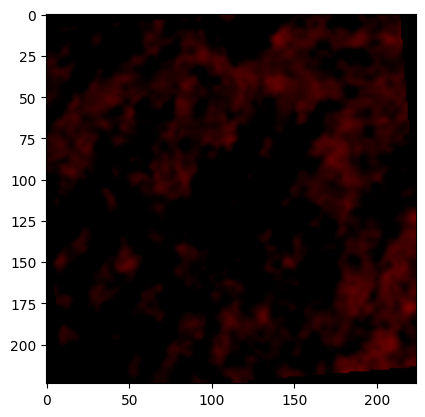

In [ ]:
print(f"Feature batch shape: {image.size()}")
print(f"Labels batch shape: {label.size()}")
img = image[0].squeeze().permute(1, 2, 0)
label = label[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
generator = torch.Generator().manual_seed(99)
train_data,val_data = random_split(dataset,[0.8,0.2],generator=generator)

In [ ]:
train_dl = DataLoader(train_data, batch_size=128, shuffle=True)
val_dl = DataLoader(val_data, batch_size=128, shuffle=True)

In [ ]:
class ISICModel(nn.Module):
    def __init__(self, model_name, in_c=3, n_classes=1, pretrained=True, features_only=False):
        super().__init__()
        self.model = create_model(
                                    model_name,
                                    pretrained=pretrained,
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg',
                                    )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = ISICModel('efficientnet_b0')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
for i,(name, param) in enumerate(model.named_parameters()):
    if i <=194:
      param.requires_grad = False
    print(i,name,param.requires_grad)

0 model.conv_stem.weight False
1 model.bn1.weight False
2 model.bn1.bias False
3 model.blocks.0.0.conv_dw.weight False
4 model.blocks.0.0.bn1.weight False
5 model.blocks.0.0.bn1.bias False
6 model.blocks.0.0.se.conv_reduce.weight False
7 model.blocks.0.0.se.conv_reduce.bias False
8 model.blocks.0.0.se.conv_expand.weight False
9 model.blocks.0.0.se.conv_expand.bias False
10 model.blocks.0.0.conv_pw.weight False
11 model.blocks.0.0.bn2.weight False
12 model.blocks.0.0.bn2.bias False
13 model.blocks.1.0.conv_pw.weight False
14 model.blocks.1.0.bn1.weight False
15 model.blocks.1.0.bn1.bias False
16 model.blocks.1.0.conv_dw.weight False
17 model.blocks.1.0.bn2.weight False
18 model.blocks.1.0.bn2.bias False
19 model.blocks.1.0.se.conv_reduce.weight False
20 model.blocks.1.0.se.conv_reduce.bias False
21 model.blocks.1.0.se.conv_expand.weight False
22 model.blocks.1.0.se.conv_expand.bias False
23 model.blocks.1.0.conv_pwl.weight False
24 model.blocks.1.0.bn3.weight False
25 model.blocks.1.0.b

In [ ]:
import numpy as np
import pandas as pd
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score

class ParticipantVisibleError(Exception):
    pass


def pauc_score(solution, submission, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC

    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC)
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.

    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''



    # check submission is numeric


    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(solution-1)

    # flip the submissions to their compliments
    v_pred = -1.0*submission

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return(partial_auc)

In [ ]:
pos_weight = torch.tensor([401059/393],dtype=torch.float32,device = device)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.001)

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    out_array = torch.empty(0,dtype = torch.float32,device = 'cpu')
    labels_array = torch.empty(0,dtype = torch.float32,device='cpu')
    for i, data in tqdm(enumerate(train_dl)):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.to(torch.float32)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs.view(-1), labels)
        out_array = torch.cat((out_array,outputs.squeeze().cpu().detach()),0)
        labels_array = torch.cat((labels_array,labels.squeeze().cpu().detach()),0)
        loss.backward()

        # Adjust learning weights
        optimizer.step()


        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dl) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            print('pAuc Score -> ' ,pauc_score(labels_array.numpy(),out_array.numpy()))


    return last_loss

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 1

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dl):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            vlabels = vlabels.to(torch.float32)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs.view(-1), vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


1000it [14:53,  1.19it/s]

  batch 1000 loss: 0.026457242824137212
pAuc Score ->  0.04826400782013683


2000it [29:38,  1.02it/s]

  batch 2000 loss: 0.010368916109669954
pAuc Score ->  0.05677237290944635


2507it [37:03,  1.13it/s]


LOSS train 0.010368916109669954 valid 0.008987754583358765


In [ ]:
torch.save(model.state_dict(), 'efficientNet.pth')

In [ ]:
## Test


In [ ]:
test_df = pd.read_csv('isic2024/test-metadata.csv')

In [ ]:
test_df

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [ ]:
import h5py
from PIL import Image
import io
import numpy as np

name = ISIC_0015657, 
 dataset = <HDF5 dataset "ISIC_0015657": shape (), type "|S3318"> 
 shape = ()
image array bytes = b'\xff\xd8\xff\xe0\x00\x10JFIF'
Shape of the image: (141, 141, 3)


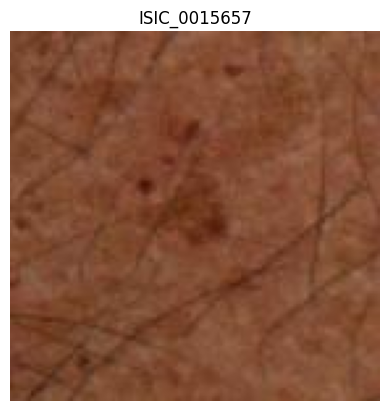

name = ISIC_0015729, 
 dataset = <HDF5 dataset "ISIC_0015729": shape (), type "|S2102"> 
 shape = ()
image array bytes = b'\xff\xd8\xff\xe0\x00\x10JFIF'
Shape of the image: (125, 125, 3)


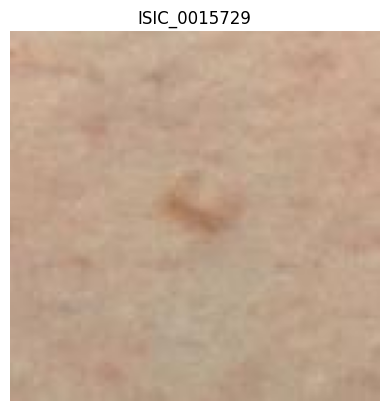

name = ISIC_0015740, 
 dataset = <HDF5 dataset "ISIC_0015740": shape (), type "|S3171"> 
 shape = ()
image array bytes = b'\xff\xd8\xff\xe0\x00\x10JFIF'
Shape of the image: (119, 119, 3)


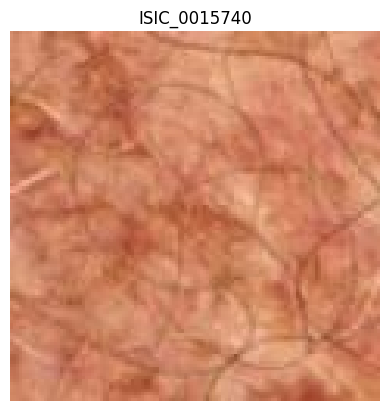

In [ ]:
file_path = 'isic2024/test-image.hdf5'

images = {}
with h5py.File(file_path, 'r') as file:
    for name, dataset in file.items():

        print(f'name = {name}, \n dataset = {dataset} \n shape = {dataset.shape}' )

        image_arr_bytes = dataset[()]
        print(f"image array bytes = {image_arr_bytes[:10]}")

        for name, val in  dataset.attrs.items():
            print (name, val)

        # Convert the byte array to a PIL image
        image = Image.open(io.BytesIO(image_arr_bytes))

        # Convert PIL image to a NumPy array
        image_array = np.array(image)

        # Store the image in the dictionary
        images[name] = image_array

        # Print the shape of the image
        print(f"Shape of the image: {image_array.shape}")

        # Display the image using matplotlib
        plt.imshow(image)
        plt.title(name)
        plt.axis('off')  # Hide axes
        plt.show()


In [ ]:
model.load_state_dict(torch.load('efficientNet.pth'))

<ipython-input-17-95792b529783>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientNet.pth'))


<All keys matched successfully>

In [ ]:
model.eval()

ISICModel(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d

In [ ]:
test_transforms = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(size=(224,224)),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
for timg in images:
  timg = test_transforms(images[timg])
  timg = timg.unsqueeze(0).to(device)
  timg.shape
  y = nn.functional.sigmoid(model(timg))
  print(y)

tensor([[3.7722e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.6410e-35]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[9.1161e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
isic_ids = []
predictions = []
for (idx, row),timg in zip(test_df.iterrows(),images):
    image_id = row['isic_id']

    # Load the image using its ID (assuming the image file format is jpg and in a folder named images/)


    # Apply the test transforms
    timg = test_transforms(images[timg])
    timg = timg.unsqueeze(0).to(device)

    # Make prediction using the model and apply sigmoid
    with torch.no_grad():
        y = nn.functional.sigmoid(model(timg))

    # Get the predicted value (convert to float)
    y_pred = y.item()

    # Append prediction to list
    isic_ids.append(image_id)
    predictions.append(y_pred)


output_df = pd.DataFrame({
    'isic_id': isic_ids,
    'target': predictions
})

# Save the new DataFrame as a CSV
output_df.to_csv('submission.csv', index=False)

In [ ]:
output_df

,isic_id,target
0,ISIC_0015657,8.100650e-10
1,ISIC_0015729,2.947660e-10
2,ISIC_0015740,3.562742e-08
